In [1]:
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time
import warnings
import numpy as np
from numpy import newaxis
import matplotlib.pyplot as plt
import pandas as pd
import pickle

Using TensorFlow backend.


In [2]:
data = pd.read_csv('EURUSD.txt')

In [3]:
data.head()

,<TICKER>,<DTYYYYMMDD>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,EURUSD,20010102,230100,0.9507,0.9507,0.9507,0.9507,4
1,EURUSD,20010102,230200,0.9506,0.9506,0.9505,0.9505,4
2,EURUSD,20010102,230300,0.9505,0.9507,0.9505,0.9506,4
3,EURUSD,20010102,230400,0.9506,0.9506,0.9506,0.9506,4
4,EURUSD,20010102,230500,0.9506,0.9506,0.9506,0.9506,4


In [4]:
data_sub = data['<OPEN>']

In [5]:
data_sub.plot()

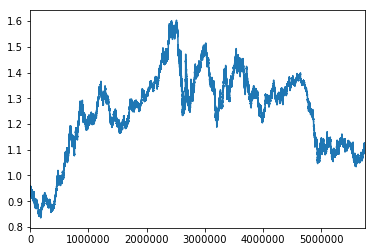

In [6]:
plt.show()

In [7]:
data_open = np.array(data_sub)
data_open = data_open[:1000000]

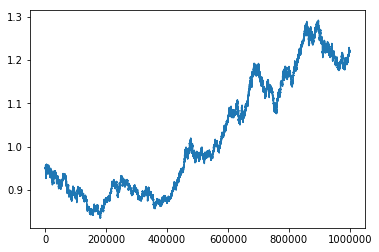

In [8]:
plt.plot(data_open)
plt.show()

In [9]:
def normalise_windows(window_data):
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return normalised_data

In [10]:
def data_prepare(data, seq_len, normalise_window):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)

    result = np.array(result)

    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

In [11]:
x_train, y_train, x_test, y_test =  data_prepare(data_open, 50, False)

In [12]:
x_train.shape

(899954, 50, 1)

In [13]:
#Step 2 Build Model
model = Sequential()

model.add(LSTM(
    input_dim=1,
    output_dim=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
    100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    output_dim=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print('compilation time : ', time.time() - start)

/home/ghost/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
/home/ghost/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(None, 1), units=50)`
  import sys


compilation time :  0.03587007522583008


/home/ghost/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  app.launch_new_instance()


In [ ]:
#Step 3 Train the model
model.fit(
    x_train,
    y_train,
    batch_size=512,
    nb_epoch=3,
    validation_split=0.05)

/home/ghost/anaconda3/lib/python3.6/site-packages/keras/models.py:851: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 854956 samples, validate on 44998 samples
Epoch 1/3
225792/854956 [======>.......................] - ETA: 2874s - loss: 0.0157

In [ ]:
def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

def predict_sequences_multiple(model, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [ ]:
x_test.shape

In [ ]:
#Step 4 - Plot the predictions!
predictions = predict_sequences_multiple(model, x_test[:500], 50, 50)

In [ ]:
def plot_results_multiple(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    #Pad the list of predictions to shift it in the graph to it's correct start
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.legend()
    plt.show()

In [ ]:
plot_results_multiple(predictions, y_test[:500], 50)

In [86]:
np.shape(predictions)

(1999, 50)